### Q: How do neutral codon probabilities compare to empirical ones?

* How does the answer depend on branch lengths?
* How do multinucleotide codon probabilities compare?

**Terminology**: the _hit class_ of a codon mutation describes the number of differences from the parent codon. E.g. `AAA -> ACT` has hit class 2. I use this terminology to avoid overloaded terms like "number of differences" which gets confusing when we are talking about number of overall differences from parent.

In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

from epam import molevol, sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict
from shmex.shm_eval import oe_plot_of, show_figure, optimized_branch_lengths_of_crepe

In [2]:
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)
model = crepe.model
site_count = 500

We're just going to use shmoof training data, the same data used to train the context NT model.

In [3]:
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["branch_length"] = pd.read_csv(crepe_path+".train_branch_lengths.csv")["branch_length"]
pcp_df = train_df

# if we want to use tang, we have to optimize branch lengths
# tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
# subsampled_tang_df = tang_df.iloc[::int(len(tang_df)/4000)].copy().reset_index(drop=True)

# take the first 1000 row
# pcp_df = pcp_df[:1000].copy()

Loading /Users/matsen/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


In [4]:
def trim_seqs_to_codon_boundary(seqs):
    return [seq[:len(seq) - len(seq) % 3] for seq in seqs]

def prepare_pcp_df(pcp_df):
    """
    Trim the sequences to codon boundaries and add the rates and substitution probabilities.
    """
    pcp_df["parent"] = trim_seqs_to_codon_boundary(pcp_df["parent"])
    pcp_df["child"] = trim_seqs_to_codon_boundary(pcp_df["child"])
    pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]].reset_index(drop=True)
    ratess, cspss = framework.trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    pcp_df["rates"] = ratess
    pcp_df["subs_probs"] = cspss
    return pcp_df

pcp_df = prepare_pcp_df(pcp_df)

#### Now let's move on to the codon-level process

In [5]:
def codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, sub_probs):
    """
    Compute the probabilities of mutating to various codons for a parent sequence. 
    
    This uses the same machinery as we use for fitting the DNSM, but we stay on
    the codon level rather than moving to syn/nonsyn changes.
    """
    # This is from `aaprobs_of_parent_scaled_rates_and_sub_probs`:
    mut_probs = 1.0 - torch.exp(-scaled_rates)
    parent_codon_idxs = reshape_for_codons(parent_idxs)
    codon_mut_probs = reshape_for_codons(mut_probs)
    codon_sub_probs = reshape_for_codons(sub_probs)
    
    # This is from `aaprob_of_mut_and_sub`:
    mut_matrices = build_mutation_matrices(parent_codon_idxs, codon_mut_probs, codon_sub_probs)
    codon_probs = codon_probs_of_mutation_matrices(mut_matrices)

    return codon_probs

The following sets us up to work with "hit classes", which are the number of differences within a codon as described above. That is, we're calculating the probability of $x$ mutations within a codon given the model.

In [6]:
# This block just sets up `hit_class_tensors`, a dictionary of tensors that we can use to compute the number of differences between codons, as well as `codon_to_idxs` which maps codons to their indices in the tensors.

# Function to calculate the number of differences between two codons
def hit_class(codon1, codon2):
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

# Initialize a dictionary to store hit_class_tensors indexed by codons
hit_class_tensors = {}

# Iterate over all possible codons and calculate the hit_class_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            hit_class_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        hit_class_tensor[i2, j2, k2] = hit_class(codon, codon_2)
            hit_class_tensors[codon] = hit_class_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_hit_class_tensor = hit_class_tensors["CTC"]
assert ctc_hit_class_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_hit_class_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_hit_class_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_hit_class_tensor[codon_to_idxs["ACT"]] == 3

In [7]:
def hit_class_probs(hit_class_tensor, codon_probs):
    """
    Calculate total probabilities for each number of differences between codons.

    Args:
    - hit_class_tensor (torch.Tensor): A 4x4x4 integer tensor containing the number of differences
                                       between each codon and a reference codon.
    - codon_probs (torch.Tensor): A 4x4x4 tensor containing the probabilities of various codons.

    Returns:
    - total_probs (torch.Tensor): A 1D tensor containing the total probabilities for each number
                                   of differences (0 to 3).
    """
    total_probs = []

    for hit_class in range(4):
        # Create a mask of codons with the desired number of differences
        mask = hit_class_tensor == hit_class

        # Multiply componentwise with the codon_probs tensor and sum
        total_prob = (codon_probs * mask.float()).sum()

        # Append the total probability to the list
        total_probs.append(total_prob.item())

    return torch.tensor(total_probs)

def hit_class_probs_seq(parent_seq, codon_probs, hit_class_tensors):
    """
    Calculate probabilities of hit classes between parent codons and all other codons for all the sites of a sequence.

    Args:
    - parent_seq (str): The parent nucleotide sequence.
    - codon_probs (torch.Tensor): A tensor containing the probabilities of various codons.
    - hit_class_tensors (dict): A dictionary containing hit_class_tensors indexed by codons.

    Returns:
    - probs (torch.Tensor): A tensor containing the probabilities of different
                            counts of hit classes between parent codons and
                            all other codons.
    """
    # Check if the size of the first dimension of codon_probs matches the length of parent_seq divided by 3
    if len(parent_seq) // 3 != codon_probs.size(0):
        raise ValueError("The size of the first dimension of codon_probs should match the length of parent_seq divided by 3.")

    # Initialize a list to store the probabilities of different counts of differences
    probs = []

    # Iterate through codons in parent_seq
    for i in range(0, len(parent_seq), 3):
        # Extract the codon from parent_seq
        codon = parent_seq[i:i+3]

        # if codon contains an N, append a tensor of 4 -1s to probs then continue
        if "N" in codon:
            probs.append(torch.tensor([-100.0] * 4))
            continue

        # Get the corresponding hit_class_tensor from hit_class_tensors
        hit_class_tensor = hit_class_tensors[codon]

        # Get the ith entry of codon_probs
        codon_probs_i = codon_probs[i // 3]

        # Calculate the probabilities of different counts of differences using the hit_class_tensor and codon_probs_i
        total_probs = hit_class_probs(hit_class_tensor, codon_probs_i)

        # Append the probabilities to the list
        probs.append(total_probs)

    # Concatenate all the probabilities into a tensor
    probs = torch.stack(probs)

    return probs


Now we need to prepare dataframes for the codon-level OE plot.

In [8]:
# This block just shows how things are going to go for a single parent sequence.

parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[9.8721e-01, 1.2739e-02, 5.0408e-05, 6.0579e-08],
        [9.8611e-01, 1.3831e-02, 6.2822e-05, 9.2978e-08],
        [9.9328e-01, 6.7103e-03, 1.2705e-05, 6.1778e-09],
        [9.9128e-01, 8.6938e-03, 2.5327e-05, 2.4519e-08],
        [9.9201e-01, 7.9667e-03, 1.9363e-05, 1.2971e-08],
        [9.9136e-01, 8.6217e-03, 1.5269e-05, 7.0076e-09]])

In [9]:
def hit_classes_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-100)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-100] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
example_hit_classes = hit_classes_of_pcp_df(example_df, 4)
example_hit_classes


tensor([[   0,    0,    1, -100],
        [   0,    0,    1,    2]])

In [10]:
def branch_length_quantile_dict_of_pcp_df(pcp_df):
    """
    Maps from the index of a row in pcp_df to the quantile of its branch length.
    """
    branch_length_quantile = pd.qcut(pcp_df["branch_length"], q=4, labels=False)
    branch_length_quantile_dict = branch_length_quantile.to_dict()
    return branch_length_quantile_dict

branch_length_quantile_dict = branch_length_quantile_dict_of_pcp_df(pcp_df)

In [11]:
def hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors):
    all_hc_probs_l = []

    for _, row in tqdm(pcp_df.iterrows(), total=len(pcp_df), desc="Computing hit class probs"):
        parent = row['parent']
        rates = row['rates']
        subs_probs = row['subs_probs']
        branch_length = row['branch_length']

        parent = parent[:len(parent) - len(parent) % 3]
        rates = rates[:len(rates) - len(rates) % 3]
        subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

        parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
        scaled_rates = branch_length * rates

        codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)

        hc_probs = hit_class_probs_seq(parent, codon_probs, hit_class_tensors)
        all_hc_probs_l.append(hc_probs)

    return all_hc_probs_l

def hc_site_df_of_pcp_df(pcp_df, hit_class_tensors):
    """
    Make a df of hit class probabilities and observations at each site in each sequence.
    """
    all_hc_probs_l = hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors)
    observed_hcs = hit_classes_of_pcp_df(pcp_df, site_count//3)
    assert len(observed_hcs) == len(pcp_df)

    df_rows = []
    for seq_idx, (observed_hc_row, hc_probs_row) in enumerate(zip(tqdm(observed_hcs, desc="Consolidating rows"), all_hc_probs_l)):
        for site_idx, (observed_hc, diff_prob_vect) in enumerate(zip(observed_hc_row, hc_probs_row[:len(observed_hc_row)])):
            if observed_hc >= 0: # filtering out N-containing codons
                v = tuple(diff_prob_vect.detach().numpy())
                df_rows.append((seq_idx, site_idx, observed_hc.item()) + v)
        
    hc_site_df = pd.DataFrame(df_rows, columns=["sequence", "site", "hit_class", "0_hc_prob", "1_hc_prob", "2_hc_prob", "3_hc_prob"])
    hc_site_df["branch_length_quantile"] = hc_site_df["sequence"].map(branch_length_quantile_dict)

    return hc_site_df

hc_site_df = hc_site_df_of_pcp_df(pcp_df, hit_class_tensors)
hc_site_df

Consolidating rows: 100%|██████████| 46386/46386 [00:24<00:00, 1920.70it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.975345,0.024490,0.000165,3.290869e-07,1
1,0,23,0,0.990078,0.009889,0.000032,3.428021e-08,1
2,0,24,0,0.988458,0.011498,0.000044,5.591491e-08,1
3,0,25,0,0.970956,0.028764,0.000279,8.890194e-07,1
4,0,26,0,0.972768,0.026985,0.000246,7.352473e-07,1
...,...,...,...,...,...,...,...,...
4346600,46385,113,0,0.979288,0.020569,0.000142,3.223395e-07,2
4346601,46385,114,0,0.972728,0.027040,0.000231,5.682003e-07,2
4346602,46385,115,0,0.977597,0.022237,0.000165,4.013761e-07,2
4346603,46385,116,0,0.986440,0.013502,0.000058,7.201321e-08,2


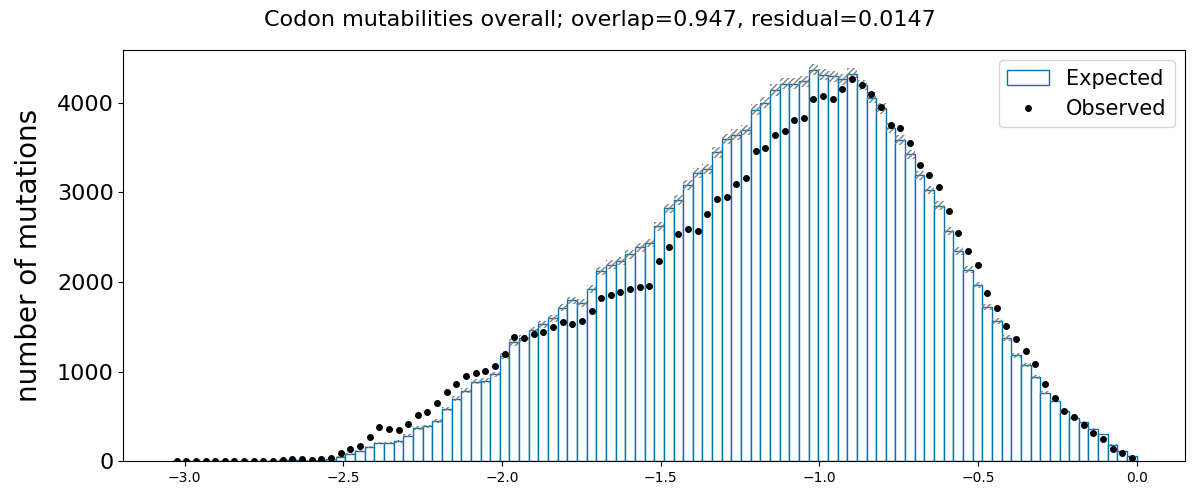

In [16]:
def simple_codon_oe_plot(hc_site_df, description):
    """
    No partitioning by mutation class.
    """
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] > 0,
        "prob": 1 - hc_site_df["0_hc_prob"],
    })
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs, None)
    fig.suptitle(f"{description}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)    
    fig.tight_layout()
    return fig, result_dict

fig, result_dict = simple_codon_oe_plot(hc_site_df, "Codon mutabilities overall")
show_figure(fig)

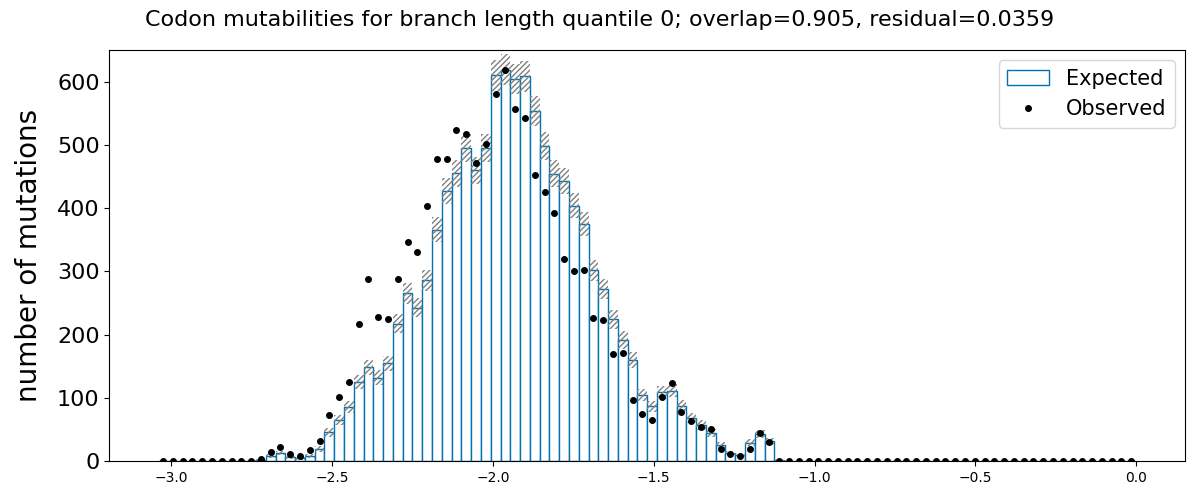

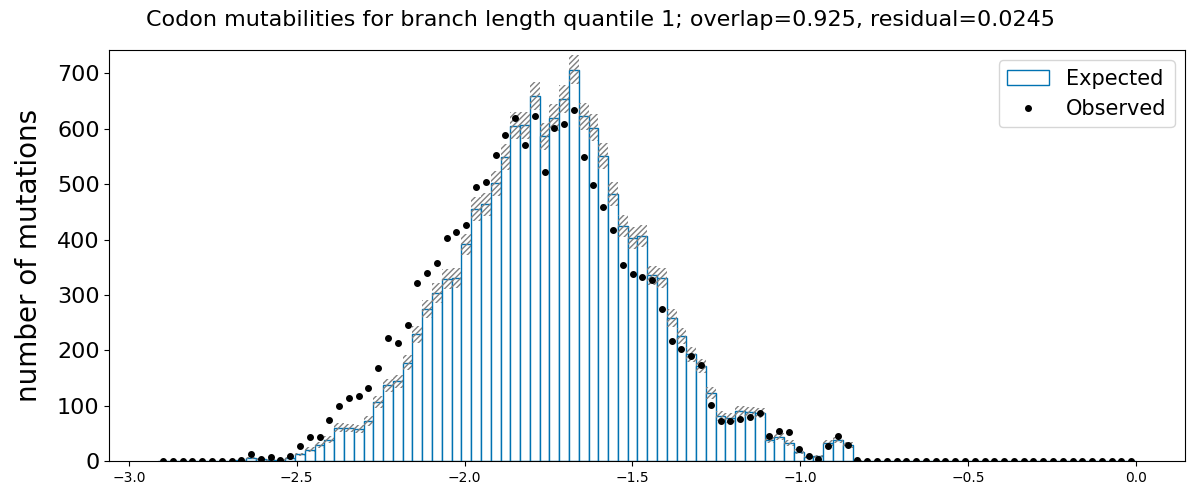

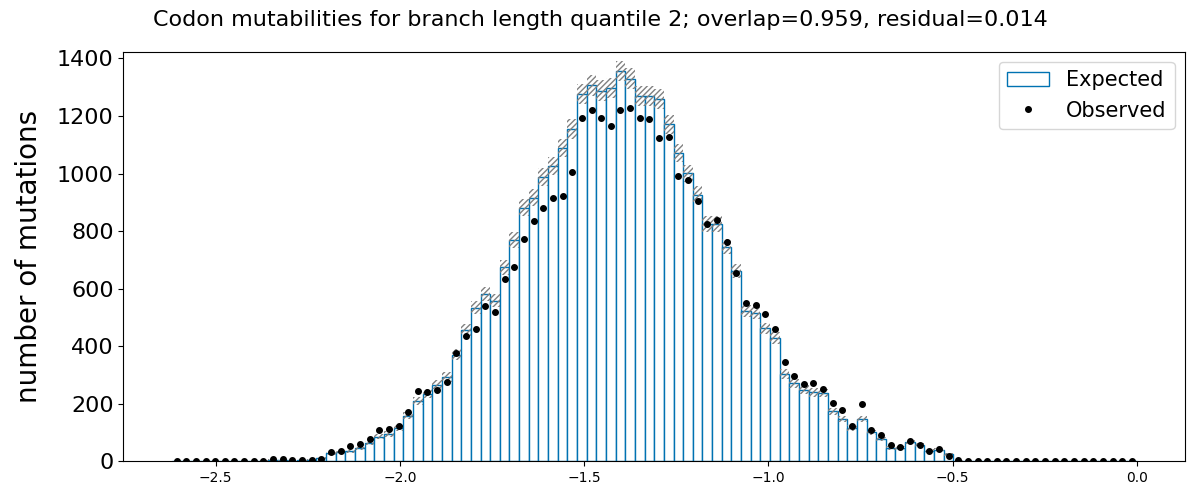

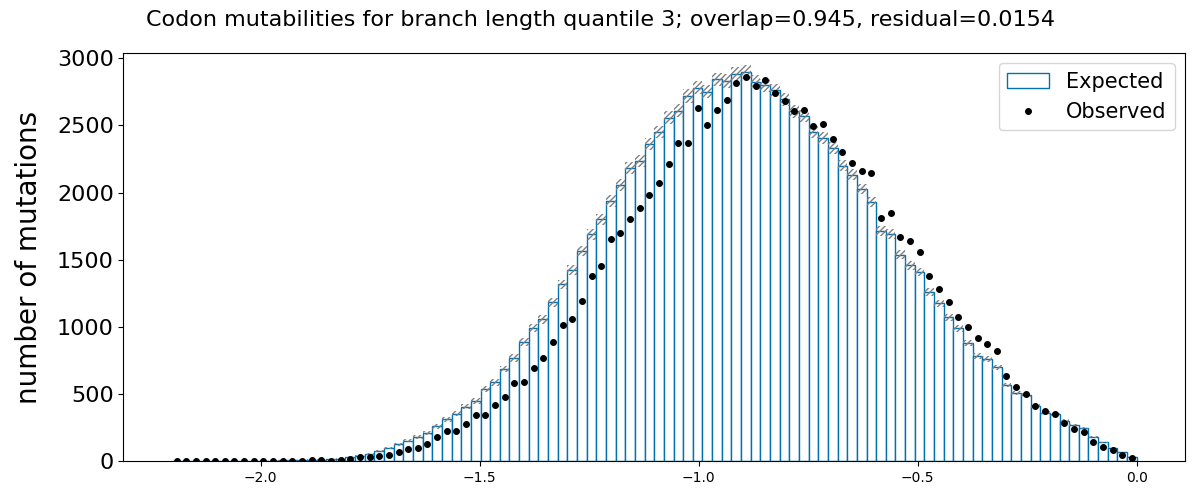

In [20]:
# loop over a groupby of pcp_df["branch_length_quantile"]
figs = []
results = []
for quantile, group in hc_site_df.groupby("branch_length_quantile"):
    fig, result = simple_codon_oe_plot(group, f"Codon mutabilities for branch length quantile {quantile}")
    show_figure(fig)
    figs.append(fig)
    results.append(result)

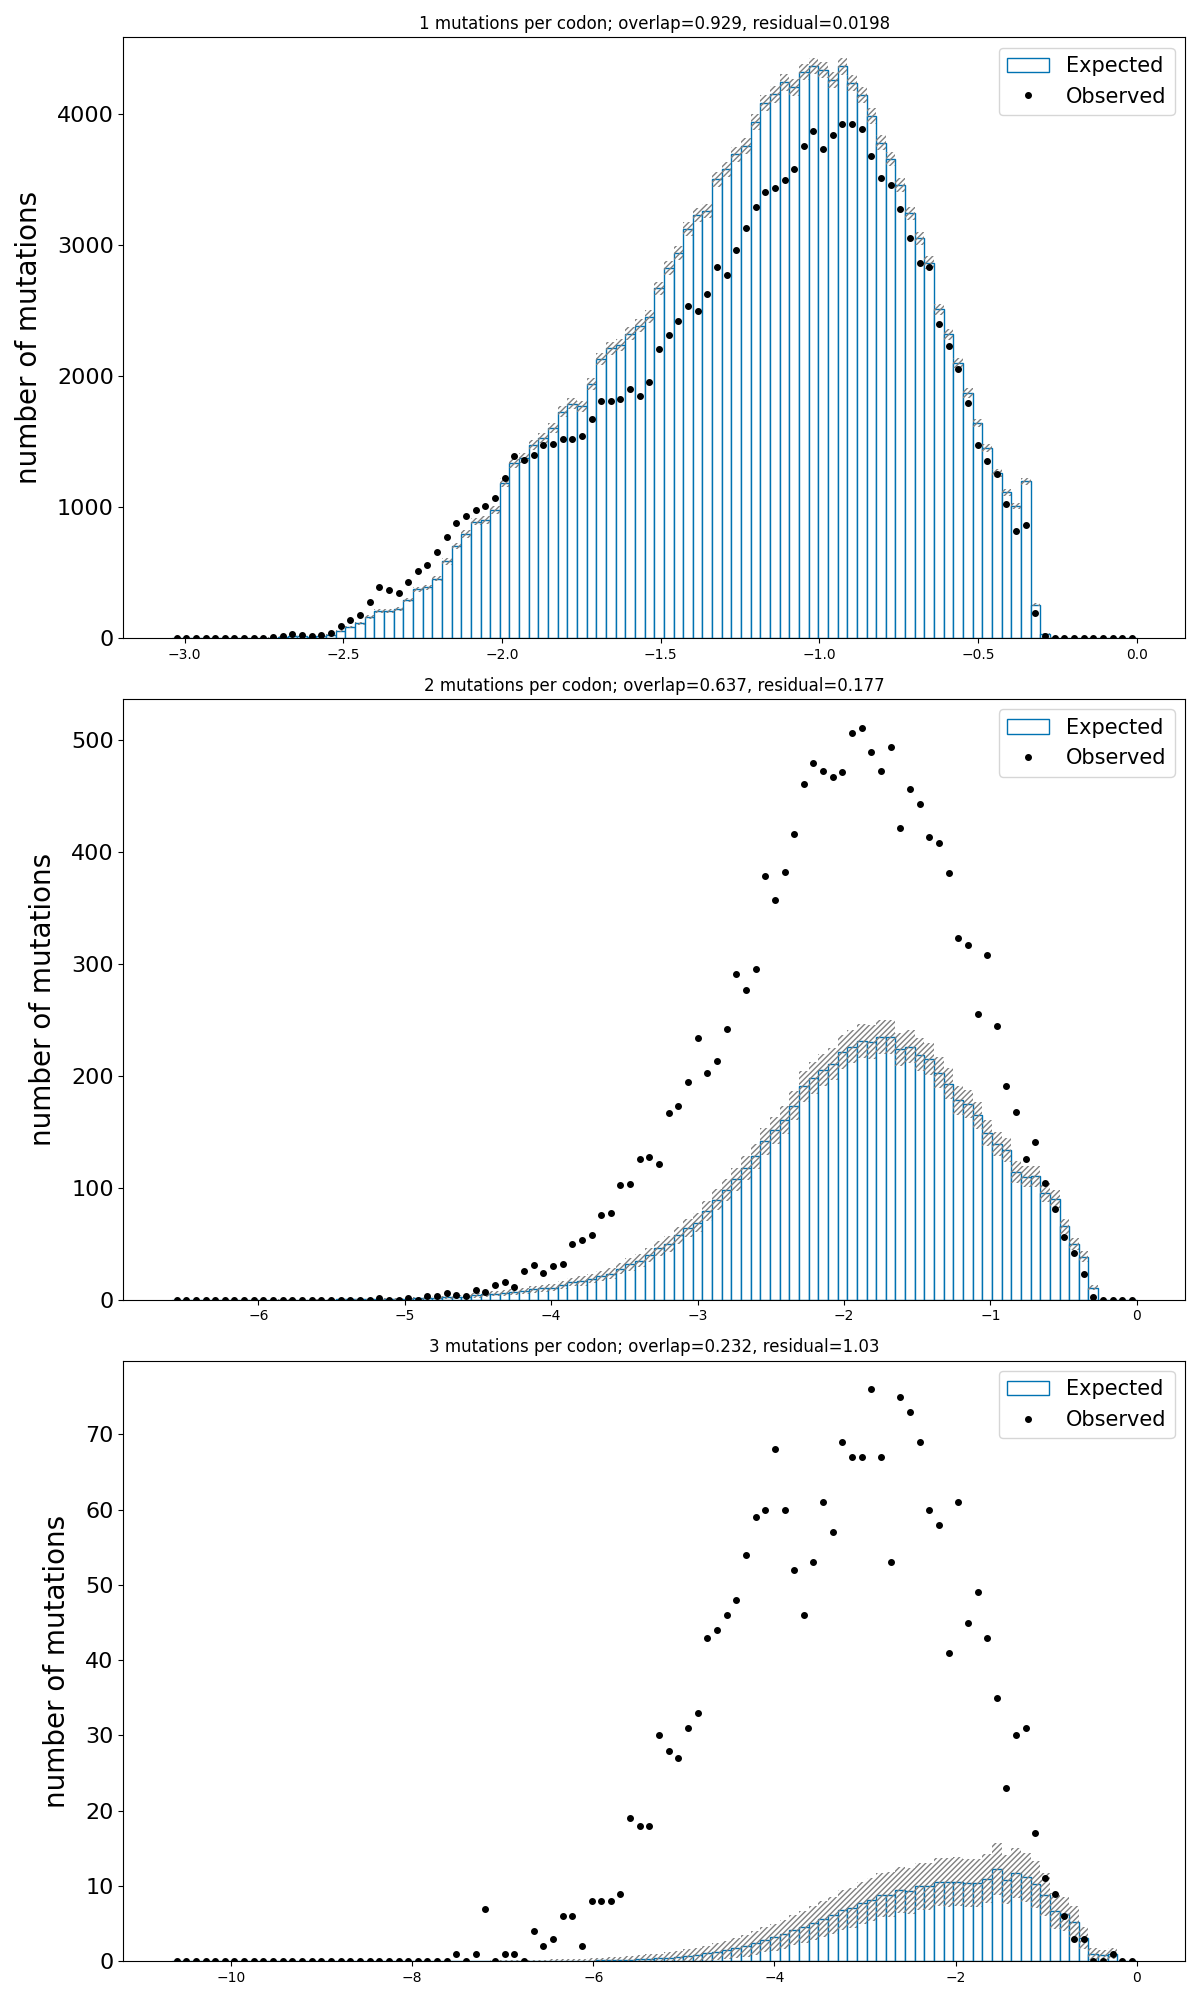

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(12, 20))

for i in range(3):
    hit_class = i + 1
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] == hit_class,
        "prob": hc_site_df[f"{hit_class}_hc_prob"],
    })
    
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[i], None)
    axs[i].set_title(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
fig.tight_layout()
fig.savefig(f"_ignore/obs_vs_exp_mutations_per_codon.png")
show_figure(fig)

### Let's look in detail about probabilities in terms of branch length

In [23]:
# select rows of pre_obs_vs_exp_df such that hit_class > 1
multihit_df = hc_site_df[hc_site_df["hit_class"] > 1].copy()
multihit_df["nt_site"] = multihit_df["site"] * 3
multihit_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile,nt_site
1348,14,67,2,0.831089,0.158858,0.009857,0.000196,3,201
1363,14,82,2,0.509091,0.402606,0.084702,0.003601,3,246
1645,18,52,2,0.680837,0.280020,0.037508,0.001635,3,156
1661,18,68,2,0.768121,0.213321,0.018115,0.000443,3,204
2717,29,27,2,0.873700,0.121172,0.005062,0.000066,3,81
...,...,...,...,...,...,...,...,...,...
4345317,46373,28,2,0.823890,0.167663,0.008348,0.000098,3,84
4345320,46373,31,3,0.877786,0.117225,0.004923,0.000066,3,93
4345321,46373,32,2,0.883157,0.112051,0.004726,0.000066,3,96
4345323,46373,34,2,0.833519,0.156507,0.009771,0.000203,3,102


In [24]:
# This block just shows things working for a single parent sequence.

parent, child, rates, subs_probs, branch_length = pcp_df.loc[14, ["parent", "child", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

# hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[[1.1005e-07, 1.8607e-07, 1.0329e-07, 1.9939e-05],
         [1.6008e-05, 2.7066e-05, 1.5025e-05, 2.9004e-03],
         [1.7314e-07, 2.9275e-07, 1.6251e-07, 3.1371e-05],
         [2.2043e-07, 3.7271e-07, 2.0690e-07, 3.9940e-05]],

        [[3.5615e-05, 6.0217e-05, 3.3428e-05, 6.4529e-03],
         [5.1807e-03, 8.7594e-03, 4.8626e-03, 9.3867e-01],
         [5.6034e-05, 9.4742e-05, 5.2594e-05, 1.0153e-02],
         [7.1339e-05, 1.2062e-04, 6.6960e-05, 1.2926e-02]],

        [[1.1034e-07, 1.8655e-07, 1.0356e-07, 1.9991e-05],
         [1.6050e-05, 2.7137e-05, 1.5065e-05, 2.9080e-03],
         [1.7360e-07, 2.9351e-07, 1.6294e-07, 3.1453e-05],
         [2.2101e-07, 3.7368e-07, 2.0744e-07, 4.0044e-05]],

        [[2.2704e-07, 3.8388e-07, 2.1311e-07, 4.1137e-05],
         [3.3027e-05, 5.5841e-05, 3.0999e-05, 5.9840e-03],
         [3.5721e-07, 6.0397e-07, 3.3529e-07, 6.4722e-05],
         [4.5478e-07, 7.6894e-07, 4.2687e-07, 8.2401e-05]]])

In [25]:
valid_length = (len(parent) // 3) * 3

# Chunk into codons and count mutations
mutations = []
for i in range(0, valid_length, 3):
    parent_codon = parent[i:i+3]
    child_codon = child[i:i+3]
    
    if parent_codon != child_codon:
        mutations.append((i, parent_codon, child_codon, codon_to_idxs[child_codon]))

multihit_sites = set([201, 246])
multihit_mutations = [m for m in mutations if m[0] in multihit_sites]
multihit_mutations, mutations

([(201, 'ACC', 'GAC', (2, 0, 1)), (246, 'AGC', 'AAG', (0, 0, 2))],
 [(123, 'GGG', 'TGG', (3, 2, 2)),
  (132, 'CTG', 'CTA', (1, 3, 0)),
  (165, 'AGC', 'GGC', (2, 2, 1)),
  (186, 'CTC', 'CGC', (1, 2, 1)),
  (198, 'GTC', 'GTA', (2, 3, 0)),
  (201, 'ACC', 'GAC', (2, 0, 1)),
  (204, 'ATA', 'ATG', (0, 3, 2)),
  (210, 'GTA', 'GGA', (2, 2, 0)),
  (219, 'TCC', 'TCG', (3, 1, 2)),
  (225, 'AAC', 'AAT', (0, 0, 3)),
  (231, 'TTC', 'CTC', (1, 3, 1)),
  (246, 'AGC', 'AAG', (0, 0, 2)),
  (249, 'TCT', 'TGT', (3, 2, 3))])

In [26]:
def mmatch_2(rates):
    """Calculate the moment matching rate for a tensor of two lambda values."""
    inv_rates = 1.0 / rates
    return 1.0 / (inv_rates.sum() - 1.0 / rates.sum())

def mmatch_3(rates):
    """Calculate the moment matching rate for a tensor of three lambda values."""
    inv_rates = 1.0 / rates
    
    # Create a matrix of pairwise sums of rates
    pairwise_sums = rates.unsqueeze(0) + rates.unsqueeze(1)
    
    # Extract the lower triangle part excluding the diagonal to avoid self-pairing
    # and ensure each pair is considered only once
    lower_tri = pairwise_sums.tril(-1)
    
    # Filter out zeros and invert each pairwise sum individually
    nonzero_pairwise_sums = lower_tri[lower_tri != 0]
    inv_nonzero_pairwise_sums = 1.0 / nonzero_pairwise_sums
    
    # Sum the inverted pairwise sums
    sum_inv_pairwise_sums = inv_nonzero_pairwise_sums.sum()

    # Final moment matching calculation for three rates
    return 1.0 / (inv_rates.sum() - sum_inv_pairwise_sums + 1.0 / rates.sum())

mmatch_2(rates[87:89])

tensor(0.6667)

In [27]:
def probability_of_mutation(branch_length, mutation):
    site, _, _, child_idxs = mutation
    scaled_rates = branch_length * rates[:parent_len]

    codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
    site_codon_probs = codon_probs[site//3]
    return site_codon_probs[child_idxs]

# make a plot of probability_of_mutation for each mutation, where branch length ranges from branch_length/2 to 2*branch_length in 100 steps
fig, ax = plt.subplots()
x_values = np.linspace(0.001, 8, 100)

for mutation in multihit_mutations:
    site, _, _, child_idxs = mutation
    probs = [probability_of_mutation(branch_length * factor, mutation) for factor in x_values]
    ax.plot(x_values, probs, label=site)

In [28]:
mmatch_2(0.1*torch.Tensor([1.1764, 1.1049]))

tensor(0.0759)

### Simulated data

In [36]:
sim_df = pd.read_csv("~/data/v0/mimic_shmoof_CNNJoiLrgShmoofSmall.10K.csv.gz", compression="gzip", index_col=0)
sim_df = prepare_pcp_df(sim_df)
sim_df["branch_length"] = optimized_branch_lengths_of_crepe(crepe, sim_df)

Finding optimal branch lengths: 100%|██████████| 9998/9998 [00:54<00:00, 184.06it/s]


In [37]:
sim_hc_site_df = hc_site_df_of_pcp_df(sim_df, hit_class_tensors)
sim_hc_site_df

Consolidating rows: 100%|██████████| 9998/9998 [00:08<00:00, 1199.75it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.991201,0.008778,0.000021,1.475248e-08,1
1,0,23,0,0.994725,0.005267,0.000009,4.636774e-09,1
2,0,24,0,0.994144,0.005845,0.000011,6.500712e-09,1
3,0,25,0,0.989451,0.010512,0.000037,4.295221e-08,1
4,0,26,0,0.990567,0.009404,0.000029,2.865033e-08,1
...,...,...,...,...,...,...,...,...
935083,9997,113,0,0.961997,0.037535,0.000466,1.835416e-06,1
935084,9997,114,0,0.967508,0.032161,0.000331,1.048159e-06,1
935085,9997,115,0,0.957846,0.041569,0.000583,2.631704e-06,1
935086,9997,116,0,0.974586,0.025196,0.000217,6.214871e-07,1


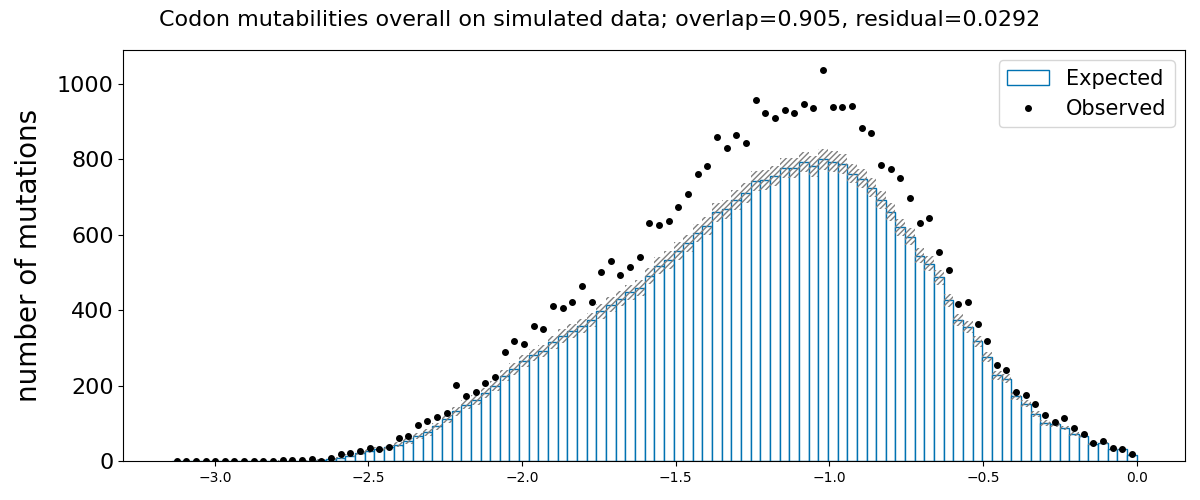

In [40]:
fig, _ = simple_codon_oe_plot(sim_hc_site_df, "Codon mutabilities overall on simulated data")
show_figure(fig)